# InternVLA-N1 Model Inferring Notebook

This notebook is used to infer the InternVLA-N1 model's by reading images and instructions from local folders. If you'd like to test the model in real world or self-built dataset, you could follow this tutorial without large **datasets download** and **simulation environment setup** (isaac-sim or habitat). Let's start!

##### 启动服务器
python scripts/eval/start_server.py --port 8087

In [9]:

# ========== 块 1: 导入依赖库 ==========
import sys
sys.path.append('.')
sys.path.append('..')

import os
import time
import numpy as np
import cv2

from internnav.configs.agent import AgentCfg
from internnav.utils import AgentClient
from scripts.iros_challenge.onsite_competition.sdk.save_obs import load_obs_from_meta

print("✓ 依赖库导入成功")



✓ 依赖库导入成功


In [10]:
# ========== 块 2: 配置参数 ==========
# 模型检查点路径（请根据实际情况修改）
checkpoint_path = '/data3/ltd/InternNav/checkpoints/InternVLA-N1-wo-dagger'

# 观察数据文件路径
rs_meta_path = '/data3/ltd/InternNav/scripts/iros_challenge/onsite_competition/captures/rs_meta.json'

# 服务器配置
server_host = 'localhost'
server_port = 8087

# 设备配置
device = 'cuda:7'

# 导航指令
instruction = 'go to the white box'

# 相机参数
camera_intrinsic = [[585.0, 0.0, 320.0], [0.0, 585.0, 240.0], [0.0, 0.0, 1.0]]
width = 640
height = 480
hfov = 79

print("配置参数：")
print(f"  检查点路径: {checkpoint_path}")
print(f"  观察数据: {rs_meta_path}")
print(f"  服务器: {server_host}:{server_port}")
print(f"  设备: {device}")
print(f"  指令: {instruction}")

配置参数：
  检查点路径: /data3/ltd/InternNav/checkpoints/InternVLA-N1-wo-dagger
  观察数据: /data3/ltd/InternNav/scripts/iros_challenge/onsite_competition/captures/rs_meta.json
  服务器: localhost:8087
  设备: cuda:7
  指令: go to the white box


In [11]:
# ========== 块 3: 验证路径 ==========
# 检查检查点路径
if os.path.exists(checkpoint_path):
    print(f"✓ 检查点路径存在: {checkpoint_path}")
    files = os.listdir(checkpoint_path)
    print(f"  包含 {len(files)} 个文件/目录")
else:
    print(f"✗ 检查点路径不存在: {checkpoint_path}")
    print("  请修改 checkpoint_path 为正确的路径")

# 检查观察数据路径
if os.path.exists(rs_meta_path):
    print(f"✓ 观察数据文件存在: {rs_meta_path}")
else:
    print(f"✗ 观察数据文件不存在: {rs_meta_path}")
    print("  请修改 rs_meta_path 为正确的路径")


✓ 检查点路径存在: /data3/ltd/InternNav/checkpoints/InternVLA-N1-wo-dagger
  包含 19 个文件/目录
✓ 观察数据文件存在: /data3/ltd/InternNav/scripts/iros_challenge/onsite_competition/captures/rs_meta.json


In [12]:
# ========== 块 4: 配置 Agent ==========
agent_cfg = AgentCfg(
    server_host=server_host,
    server_port=server_port,
    model_name='internvla_n1',
    ckpt_path='',
    model_settings={
        'policy_name': "InternVLAN1_Policy",
        'state_encoder': None,
        'env_num': 1,
        'sim_num': 1,
        'model_path': checkpoint_path,
        'camera_intrinsic': camera_intrinsic,
        'width': width,
        'height': height,
        'hfov': hfov,
        'resize_w': 384,
        'resize_h': 384,
        'max_new_tokens': 1024,
        'num_frames': 32,
        'num_history': 8,
        'num_future_steps': 4,
        'device': device,
        'predict_step_nums': 32,
        'continuous_traj': True,
        'infer_mode': 'partial_async',
        # Debug settings
        'vis_debug': False,
        'vis_debug_path': './logs/test_n1/vis_debug',
    }
)

print("✓ Agent 配置创建成功")
print(f"  模型名称: {agent_cfg.model_name}")
print(f"  模型路径: {agent_cfg.model_settings['model_path']}")


✓ Agent 配置创建成功
  模型名称: internvla_n1
  模型路径: /data3/ltd/InternNav/checkpoints/InternVLA-N1-wo-dagger


In [13]:
# ========== 块 5: 初始化 Agent Client ==========
# ⚠️ 注意：运行此块前，请确保服务器已启动！
# 在终端运行：python scripts/eval/start_server.py --port 8087

print(f"连接到服务器 {server_host}:{server_port}...")

try:
    agent = AgentClient(agent_cfg)
    print("✓ Agent 客户端初始化成功！")
    print("  模型已加载到服务器")
except Exception as e:
    print(f"✗ 初始化失败: {e}")
    print("\n请检查：")
    print("  1. 服务器是否正在运行")
    print("  2. 端口号是否正确")
    print("  3. 检查点路径是否正确")
    raise

连接到服务器 localhost:8087...
✓ Agent 客户端初始化成功！
  模型已加载到服务器


In [14]:
# ========== 块 6: 加载观察数据 ==========
# 加载观察数据
obs = load_obs_from_meta(rs_meta_path)

# 添加导航指令
obs['instruction'] = instruction

print("✓ 观察数据加载成功")
print(f"  RGB shape: {obs['rgb'].shape}")
print(f"  Depth shape: {obs['depth'].shape}")
print(f"  Instruction: {obs['instruction']}")
print(f"  Timestamp: {obs['timestamp_s']}")

/data3/ltd/InternNav/scripts/iros_challenge/onsite_competition/captures/rs_rgb.jpg /data3/ltd/InternNav/scripts/iros_challenge/onsite_competition/captures/rs_depth_mm.png
{'rgb': array([[[138, 142, 170],
        [118, 122, 150],
        [104, 103, 135],
        ...,
        [ 24,  63, 179],
        [ 25,  62, 178],
        [ 23,  60, 176]],

       [[105, 109, 138],
        [ 99, 101, 131],
        [ 99,  98, 130],
        ...,
        [ 25,  64, 180],
        [ 25,  62, 178],
        [ 22,  59, 175]],

       [[106, 108, 139],
        [108, 110, 141],
        [115, 114, 146],
        ...,
        [ 25,  62, 178],
        [ 25,  62, 178],
        [ 23,  60, 176]],

       ...,

       [[  9,  16,  25],
        [ 10,  19,  28],
        [ 11,  20,  29],
        ...,
        [ 12,  42, 113],
        [ 11,  41, 112],
        [ 11,  41, 112]],

       [[ 10,  16,  27],
        [  8,  17,  27],
        [  9,  18,  27],
        ...,
        [ 15,  43, 114],
        [ 13,  41, 112],
        [ 

In [15]:
print(f"  包含 {len(obs['rgb'])} 帧数据")
print("观察数据键：", list(obs.keys()))

  包含 480 帧数据
观察数据键： ['rgb', 'depth', 'timestamp_s', 'intrinsics', 'instruction']


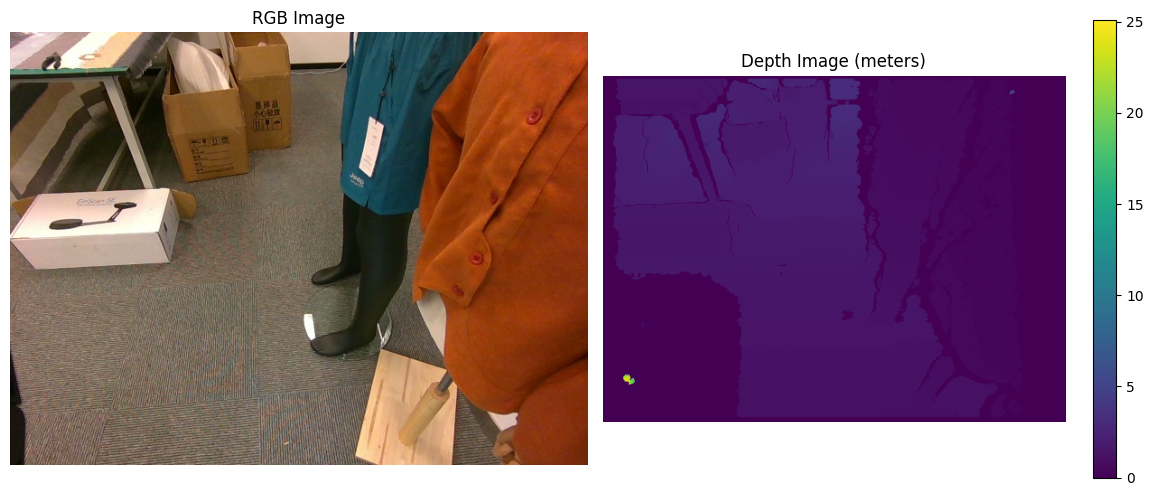

Depth range: 0.00m - 25.09m


In [47]:
# ========== 块 7: 可视化观察数据（可选）==========
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RGB 图像（BGR -> RGB）
rgb_display = cv2.cvtColor(obs['rgb'], cv2.COLOR_BGR2RGB)
axes[0].imshow(rgb_display)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# 深度图像
depth_display = obs['depth']
im = axes[1].imshow(depth_display, cmap='viridis')
axes[1].set_title('Depth Image (meters)')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"Depth range: {np.nanmin(depth_display):.2f}m - {np.nanmax(depth_display):.2f}m")


In [48]:
# ========== 块 8: 运行模型推理 ==========
print("开始推理...")
print(f"指令: {obs['instruction']}")
print()

# 记录开始时间
start_time = time.time()

# 执行推理
result = agent.step([obs])

# 计算推理时间
inference_time = time.time() - start_time

# 提取动作
action = result[0]['action'][0]

print("=" * 80)
print("推理结果")
print("=" * 80)
print(f"预测动作: {action}")
print(f"推理时间: {inference_time:.2f} 秒")
print("=" * 80)

开始推理...
指令: go to the white box

推理结果
预测动作: 2
推理时间: 1.53 秒


In [1]:
# ========== 块 9: 输出可视化函数 ==========
from PIL import Image, ImageDraw, ImageFont
import cv2

def annotate_image(idx, image, llm_output, trajectory, pixel_goal, output_dir):
    image = Image.fromarray(image)#.save(f'rgb_{idx}.png')
    draw = ImageDraw.Draw(image)
    font_size = 20
    font = ImageFont.truetype("DejaVuSansMono.ttf", font_size)
    text_content = []
    text_content.append(f"Frame    Id  : {idx}")
    text_content.append(f"Actions      : {llm_output}" )
    max_width = 0
    total_height = 0
    for line in text_content:
        bbox = draw.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = 26
        max_width = max(max_width, text_width)
        total_height += text_height

    padding = 10
    box_x, box_y = 10, 10
    box_width = max_width + 2 * padding
    box_height = total_height + 2 * padding

    draw.rectangle([box_x, box_y, box_x + box_width, box_y + box_height], fill='black')

    text_color = 'white'
    y_position = box_y + padding
    
    for line in text_content:
        draw.text((box_x + padding, y_position), line, fill=text_color, font=font)
        bbox = draw.textbbox((0, 0), line, font=font)
        text_height = 26
        y_position += text_height
    image = np.array(image)
    
    # Draw trajectory visualization in the top-right corner using matplotlib
    if trajectory is not None and len(trajectory) > 0:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        
        img_height, img_width = image.shape[:2]
        
        # Window parameters
        window_size = 200  # Window size in pixels
        window_margin = 0  # Margin from edge
        window_x = img_width - window_size - window_margin
        window_y = window_margin
        
        # Extract trajectory points
        traj_points = []
        for point in trajectory:
            if isinstance(point, (list, tuple, np.ndarray)) and len(point) >= 2:
                traj_points.append([float(point[0]), float(point[1])])
        
        if len(traj_points) > 0:
            traj_array = np.array(traj_points)
            x_coords = traj_array[:, 0]
            y_coords = traj_array[:, 1]
            
            # Create matplotlib figure
            fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
            fig.patch.set_alpha(0.6)  # Semi-transparent background
            fig.patch.set_facecolor('gray')
            ax.set_facecolor('lightgray')
            
            # Plot trajectory
            # Coordinate system: x-axis points up, y-axis points left
            # Origin at bottom center
            ax.plot(y_coords, x_coords, 'b-', linewidth=2, label='Trajectory')
            
            # Mark start point (green) and end point (red)
            ax.plot(y_coords[0], x_coords[0], 'go', markersize=6, label='Start')
            ax.plot(y_coords[-1], x_coords[-1], 'ro', markersize=6, label='End')
            
            # Mark origin
            ax.plot(0, 0, 'w+', markersize=10, markeredgewidth=2, label='Origin')
            
            # Set axis labels
            ax.set_xlabel('Y (left +)', fontsize=8)
            ax.set_ylabel('X (up +)', fontsize=8)
            ax.invert_xaxis()
            ax.tick_params(labelsize=6)
            ax.grid(True, alpha=0.3, linewidth=0.5)
            
            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')
            
            # Add legend
            ax.legend(fontsize=6, loc='upper right')
            
            # Adjust layout
            plt.tight_layout(pad=0.3)
            
            # Convert matplotlib figure to numpy array
            canvas = FigureCanvasAgg(fig)
            canvas.draw()
            plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
            plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close(fig)
            
            # Resize plot to fit window
            plot_img = cv2.resize(plot_img, (window_size, window_size))
            
            # Overlay plot on image
            image[window_y:window_y+window_size, window_x:window_x+window_size] = plot_img
    
    if pixel_goal is not None:
        cv2.circle(image, (pixel_goal[1], pixel_goal[0]), 5, (255, 0, 0), -1)
    image = Image.fromarray(image).convert('RGB')
    image.save(f'{output_dir}/rgb_{idx}_annotated.png')
    # to numpy array
    return np.array(image)

In [ ]:
# ========== 块 10: 查看完整结果（调试用）==========

In [ ]:
# Reset agent
agent.reset()
print(f"{'='*80}")
print(f"Processing scene: {os.path.basename(scene_dir)}")
print(f"Instruction: '{instruction}'")
print(f"Total images: {len(rgb_paths)}")
print(f"{'='*80}\n")


    
# Read RGB image
rgb = np.asarray(Image.open(rgb_path).convert('RGB'))

# Create dummy depth image (not available in test data)
# !Note You must full in depth to model
depth = 10 * np.ones((rgb.shape[0], rgb.shape[1]), dtype=np.float32)

# Create dummy camera pose
camera_pose = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Run model or just save image
# print(f"[{i+1}/{len(rgb_paths)}] Running model inference: {os.path.basename(rgb_path)}")
with torch.no_grad():   
    dual_sys_output = agent.step([obs]
    )

# Print output results
if dual_sys_output.output_action is not None and dual_sys_output.output_action != []:
    print(f"  Output action: {dual_sys_output.output_action}")
    # action_seq.extend(s2_output.output_action)
else:
    
    print(f"output_trajectory: {dual_sys_output.output_trajectory.tolist()}")
    if dual_sys_output.output_pixel is not None:
        print(f"output_pixel: {dual_sys_output.output_pixel}")
        annotate_image(image_id, rgb, 'traj', dual_sys_output.output_trajectory.tolist(), dual_sys_output.output_pixel, save_dir)


print(f"\nScene {os.path.basename(scene_dir)} completed!")


In [ ]:
# ========== 块 10: 动作可视化 ==========
import glob
from PIL import Image
import matplotlib.pyplot as plt

for img_path in sorted(glob.glob(f'{save_dir}/*_annotated.png')):
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.show()

In [49]:
# ========== 块 9: 解析动作 ==========
# 动作映射
action_map = {
    0: "MOVE_FORWARD",
    1: "TURN_RIGHT",
    2: "TURN_LEFT",
    3: "STOP"
}

action_names = {
    0: "前进",
    1: "右转",
    2: "左转",
    3: "停止"
}

if action in action_map:
    print(f"动作编号: {action}")
    print(f"动作名称: {action_map[action]}")
    print(f"中文含义: {action_names[action]}")
else:
    print(f"未知动作: {action}")

print(f"\n✓ 测试完成！模型成功预测了动作。")


# ========== 块 10: 查看完整结果（调试用）==========
print("完整结果字典：")
print()
for key, value in result[0].items():
    print(f"{key}:")
    if isinstance(value, np.ndarray):
        print(f"  类型: numpy.ndarray")
        print(f"  形状: {value.shape}")
        print(f"  数据类型: {value.dtype}")
        if value.size < 10:
            print(f"  值: {value}")
    else:
        print(f"  值: {value}")
    print()


动作编号: 2
动作名称: TURN_LEFT
中文含义: 左转

✓ 测试完成！模型成功预测了动作。
完整结果字典：

action:
  值: [2]

ideal_flag:
  值: True



In [50]:
# ========== 块 11: 批量测试（可选）==========
# 示例：测试不同的指令
test_instructions = [
    'Go to the mannequin',
    'Find the cardboard boxes.',
    'Move forward one meter',
    'Turn right towards the mannequin.'
]

print("批量测试不同指令：")
print("=" * 80)

for idx, test_instruction in enumerate(test_instructions, 1):
    # 创建新的观察数据
    test_obs = obs.copy()
    test_obs['instruction'] = test_instruction

    # 执行推理
    start_time = time.time()
    result = agent.step([test_obs])
    inference_time = time.time() - start_time

    action = result[0]['action'][0]

    # 输出结果
    print(f"测试 {idx}: {test_instruction}")
    print(f"  动作: {action} ({action_map.get(action, 'Unknown')} / {action_names.get(action, '未知')})")
    print(f"  时间: {inference_time:.2f}s")
    print()

print("=" * 80)
print("批量测试完成！")

批量测试不同指令：
测试 1: Go to the mannequin
  动作: 2 (TURN_LEFT / 左转)
  时间: 0.03s

测试 2: Find the cardboard boxes.
  动作: 2 (TURN_LEFT / 左转)
  时间: 0.03s

测试 3: Move forward one meter
  动作: 2 (TURN_LEFT / 左转)
  时间: 0.03s

测试 4: Turn right towards the mannequin.
  动作: -1 (Unknown / 未知)
  时间: 1.02s

批量测试完成！


In [39]:
# ========== 块 12: 保存测试结果（可选）==========
import json
from datetime import datetime

# 准备保存的结果
test_result = {
    'timestamp': datetime.now().isoformat(),
    'checkpoint': checkpoint_path,
    'instruction': instruction,
    'action': int(action),
    'action_name': action_map.get(action, 'Unknown'),
    'inference_time': inference_time,
    'device': device,
}

# 保存到文件
output_file = 'test_result.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(test_result, f, indent=2, ensure_ascii=False)

print(f"✓ 测试结果已保存到: {output_file}")
print("\n内容：")
print(json.dumps(test_result, indent=2, ensure_ascii=False))

✓ 测试结果已保存到: test_result.json

内容：
{
  "timestamp": "2026-01-13T11:57:42.168638",
  "checkpoint": "/data3/ltd/InternNav/checkpoints/InternVLA-N1-wo-dagger",
  "instruction": "go to the white box",
  "action": -1,
  "action_name": "Unknown",
  "inference_time": 1.0236234664916992,
  "device": "cuda:7"
}
